# Создание масок

Маски сегментации задаются в виде строк, закодированных в rle. Преобразуем закодированные маски в изображения и сохраняем их. Парные данные x, y, используемые для обучения модели сегментации, представляют собой обучающее изображение и сохраненное изображение сегментации соответственно. Поскольку модель сегментации будет обучаться только на изображениях с кораблями в них, маски будут сохраняться только для кораблей, содержащих изображения.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50
from skimage.morphology import label
import json

In [7]:
torch.backends.cudnn.benchmark=True

In [8]:
PATH = Path('F:/ships')

In [10]:
seg_df = pd.read_csv(PATH/'train_ship_segmentations_v2.csv')

In [11]:
seg_df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [13]:
seg_df.shape

(231723, 2)

In [15]:
files = os.listdir(PATH/'train_v2')

In [16]:
len(files)

192556

In [18]:
def rle_encode(img, min_threshold=1e-3, max_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_threshold:
        return '' ## no need to encode if it's all zeros
    if max_threshold and np.mean(img) > max_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [19]:
def multi_rle_encode(img):
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2)) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

In [20]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [21]:
def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

In [22]:
def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

The dataset contains 192556 images total. 42556 images contain ships with a total of 81723 distinct ship masks.

In [23]:
not_empty = pd.notna(seg_df.EncodedPixels)
not_empty.sum(), seg_df[not_empty].ImageId.nunique()

(81723, 42556)

In [25]:
(~not_empty).sum(), seg_df[~not_empty].ImageId.nunique()

(150000, 150000)

In [26]:
rle_0 = seg_df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
img_0

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

Check Decoding->Encoding RLE_0: 9 -> RLE_1: 4
0 error


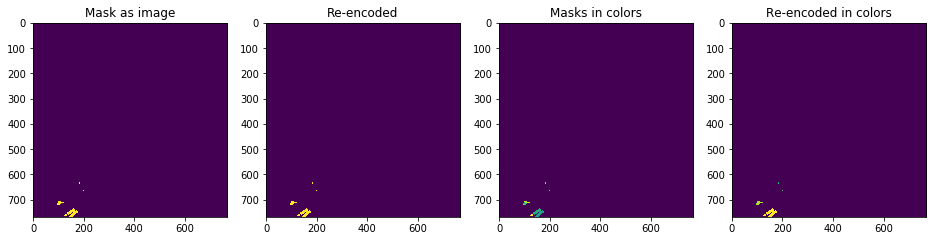

In [28]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (16, 5))
rle_0 = seg_df.query('ImageId=="00021ddc3.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0)
ax1.set_title('Mask as image')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1)
ax2.set_title('Re-encoded')
img_c = masks_as_color(rle_0)
ax3.imshow(img_c)
ax3.set_title('Masks in colors')
img_c = masks_as_color(rle_1)
ax4.imshow(img_c)
ax4.set_title('Re-encoded in colors')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
print(np.sum(img_0 - img_1), 'error')

In [29]:
seg_df[not_empty].head()

,ImageId,EncodedPixels
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...


In [31]:
seg_df['ships'] = seg_df['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

In [33]:
unique_img_ids = seg_df.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

In [34]:
unique_img_ids.head()

,ImageId,ships,has_ship
0,00003e153.jpg,0,0.0
1,0001124c7.jpg,0,0.0
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
4,0001b1832.jpg,0,0.0


In [36]:
ship_files = unique_img_ids[unique_img_ids.has_ship>0].ImageId.values

In [37]:
empty_files = unique_img_ids[unique_img_ids.has_ship==0].ImageId.values

In [38]:
len(ship_files), len(empty_files)

(42556, 150000)

In [39]:
seg_df[seg_df.ImageId.isin(ship_files)].head()

,ImageId,EncodedPixels,ships
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1


In [40]:
len(seg_df[seg_df.ImageId.isin(ship_files)].ImageId.unique())

42556

In [42]:
samp_df = seg_df[seg_df.ImageId.isin(ship_files)].copy()

In [43]:
samp_df.reset_index(inplace=True)

In [44]:
samp_df.head()

,index,ImageId,EncodedPixels,ships
0,2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
1,3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,1
2,4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,1
3,5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...,1
4,6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...,1


In [45]:
samp_unique = unique_img_ids[unique_img_ids.ImageId.isin(ship_files)]

Some images contain multiple ships

In [46]:
samp_unique.head()

,ImageId,ships,has_ship
2,000155de5.jpg,1,1.0
3,000194a2d.jpg,5,1.0
5,00021ddc3.jpg,9,1.0
6,0002756f7.jpg,2,1.0
9,00031f145.jpg,1,1.0


In [47]:
len(samp_unique.ImageId.unique())

42556

In [48]:
samp_unique.shape, samp_df.shape

((42556, 3), (81723, 4))

In [49]:
enc_group = samp_df.groupby('ImageId')

In [50]:
image_fns = samp_unique.ImageId.values

In [52]:
def get_mask(im, gb):
    rle = gb.get_group(im).EncodedPixels
    im_mask = masks_as_image(rle)

    im_mask = im_mask*255
    out_mask = np.stack([im_mask, im_mask, im_mask], axis=2)

    out_im = Image.fromarray(out_mask)

    fn = f'{im[:-4]}_mask.png'
    out_im.save(PATH/'masks'/fn, "PNG")

In [53]:
def multi_masks(filenames, gb):
    with ThreadPoolExecutor(8) as e:
        e.map(lambda x: get_mask(x, gb), filenames)

In [55]:
%time multi_masks(image_fns, enc_group)

Wall time: 2min 57s


In [57]:
mask_files = os.listdir(PATH/'masks')

In [59]:
ims = [open_image(PATH/'masks'/mask_files[i]) for i in range(16)]

In [60]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

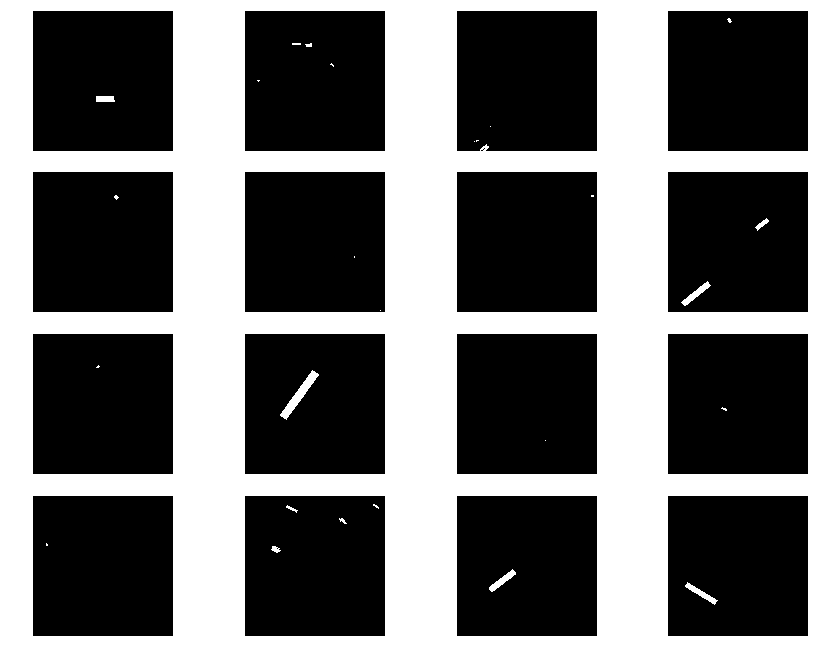

In [62]:
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    
plt.tight_layout(pad=0.1)

In [66]:
mask_to_ship = [i.split('_')[0] + '.jpg' for i in mask_files]

In [69]:
ship_ims = [open_image(PATH/'train_v2'/mask_to_ship[i]) for i in range(16)]

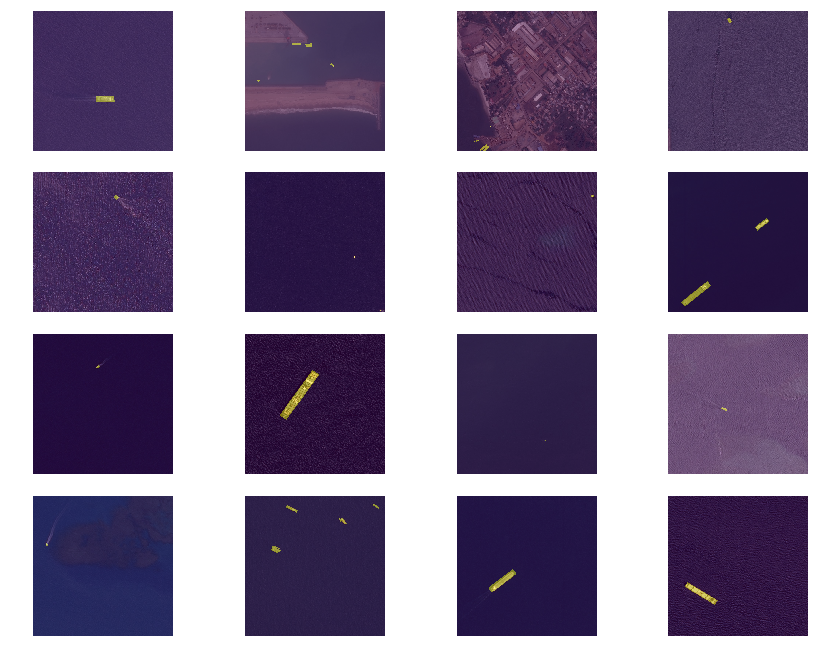

In [70]:
fig, axes = plt.subplots(4, 4, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    ax = show_img(ship_ims[i], ax=ax)
    show_img(ims[i][...,0], ax=ax, alpha=0.5)
    
plt.tight_layout(pad=0.1)

# Сегментационная модель U-net

Модель U-Net

Мы хотим, чтобы модель обработала изображение, а затем вернула маску того же размера, что и исходное изображение. Один из способов сделать это состоит в том, чтобы сначала использовать сверточную модель в качестве кодера для обработки входного изображения в меньший, более глубокий тензор. Затем используем декодер, чтобы увеличить частоту с этого сверточного вывода до исходного размера изображения. Эта стратегия работает, но только так хорошо. Проблема заключается в том, что огромное количество информации на входе сжимается в сверточный вывод кодера. Попытка распаковать это с высокой степенью точности, необходимой для маскировки, является очень сложной задачей. Хорошие маски требуют мелких деталей по краям - точные границы важны. Попытка сохранить эту информацию с помощью сверточного кодера довольно сложная.

U-Net предлагает решение для этого. Модель U-Net сохраняет активации из более ранних уровней в кодере и передает их в декодер во время повышающей дискретизации. Это позволяет декодеру сохранять информацию изображения из ранних сверточных слоев. Эта архитектура гораздо более опытна в производстве масок высокого качества. Визуально U-Net выглядит так:

![img](unet.png)

[source](https://arxiv.org/pdf/1505.04597.pdf)

## Предварительно обученные кодеры

Одним из способов повысить производительность модели U-Net является использование предварительно кодированной модели для кодера. Предварительно обученные модели уже разработали веса, необходимые для основных функций обработки изображений, таких как обнаружение краев и текстур. Эти преимущества распространяются даже на такие задачи распознавания изображений, как обработка сейсмических изображений. Модель, обученная в этом задании, использует предварительно обученную модель resnet34 в качестве кодера.

## Loss функция

Сегментацию можно рассматривать как проблему классификации - вы хотите классифицировать каждый пиксель во входном изображении как 0 или 1 в зависимости от того, является ли он частью маски или нет. Простая функция потерь, которая работает для этой задачи, была бы двоичной перекрестной энтропией. Однако мы можем получить лучшую производительность, если добавим к этому.

Когда дело доходит до производства высококачественных масок, трудность находится на краю маски. Внутри маски есть группа пикселей, классифицированных как 1, все сгруппированы вместе. За пределами маски каждый пиксель классифицируется как 0. Классифицировать большую часть внутренней части маски 1 и большую часть внешней части как 0 довольно легко. Сложность в сегментации происходит на границах, где маска переходит от большей части 1 к большей части 0. Визуально говоря, создание блобных плохо определенных масок легко. Создание масок с острыми, точными, четко очерченными краями сложно.

Чтобы подтолкнуть модель к обращению внимания на границы, мы добавляем компонент потери мягких костей в функцию потерь. Оценка кубиков показывает, насколько похожа предсказанная маска на целевую маску, если посмотреть на соотношение истинных позитивов к истинным позитивам плюс ложных позитивов плюс ложных негативов. Для численной устойчивости мы добавляем натуральный логарифм костей к функции потерь.

Дополнительная проблема с этим набором данных состоит в том, что многие из кораблей, которые нам нужно сегментировать, очень малы. Это приводит к несбалансированной проблеме классификации. Фактически, многие изображения настолько несбалансированы, что модель может достичь точности 99%, предсказывая пустые маски, так как большая часть области на каждом изображении - просто пустой океан. Мы хотим избежать этого.

Другая проблема, которая возникает, состоит в том, что стандартная функция кросс-энтропии дает слишком сильное наказание за правильные классификации, которые не имеют достаточно высокой вероятности (то есть получение правильного класса, но с вероятностью 65%). В результате модель не сможет классифицировать небольшие объекты, вместо этого выбрав классифицировать все как фон, потому что было слишком сильное наказание за правильность, но недостаточно правильную. Решением этих проблем является использование [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf), показана версия перекрестной энтропии для улучшения классификации мелких объектов. Фокусная потеря взвешивает перекрестную потерю энтропии:

$$-\alpha*(1-p_{t})^\gamma * log(p_{t})$$

Где

$$
p_{t} = \left\{
        \begin{array}{ll}
            p & \quad x = 0 \\
            1-p & \quad otherwise
        \end{array}
    \right.
$$

Влияние коэффициента фокальных потерь состоит в том, чтобы ослабить вклад потерь в классификациях с более высокой вероятностью и сосредоточить модель на плохо классифицированных примерах.

In [6]:
mask_fns = os.listdir(PATH/'masks')

In [8]:
trn_fns = [i.split('_')[0] + '.jpg' for i in mask_fns]

In [10]:
TRAIN_DN = 'train_v2'

In [11]:
MASKS_DN = 'masks'

In [12]:
x_names = np.array([Path(TRAIN_DN)/o for o in trn_fns])
y_names = np.array([Path(MASKS_DN)/o for o in mask_fns])

In [13]:
x_names[0]

WindowsPath('train_v2/000155de5.jpg')

In [14]:
y_names[0]

WindowsPath('masks/000155de5_mask.png')

In [15]:
n = len(x_names)
n

42556

In [16]:
val_idxs = get_cv_idxs(n, val_pct=0.15)

In [17]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [18]:
test_x = PIL.Image.open(PATH/x_names[0])
np.array(test_x).shape

(768, 768, 3)

In [19]:
test_y = PIL.Image.open(PATH/y_names[0])
np.array(test_y).shape

(768, 768, 3)

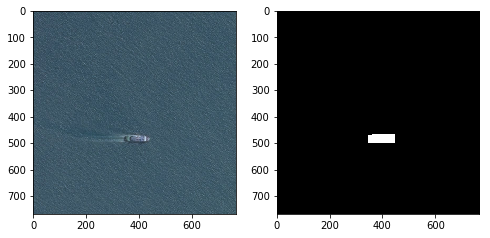

In [20]:
fig = plt.figure(figsize=(8,8))
fig.add_subplot(1,2,1)
plt.imshow(test_x)
fig.add_subplot(1,2,2)
plt.imshow(test_y)

In [21]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [22]:
ims = [open_image(PATH/x_names[i]) for i in range(16)]
im_masks = [open_image(PATH/y_names[i]) for i in range(16)]

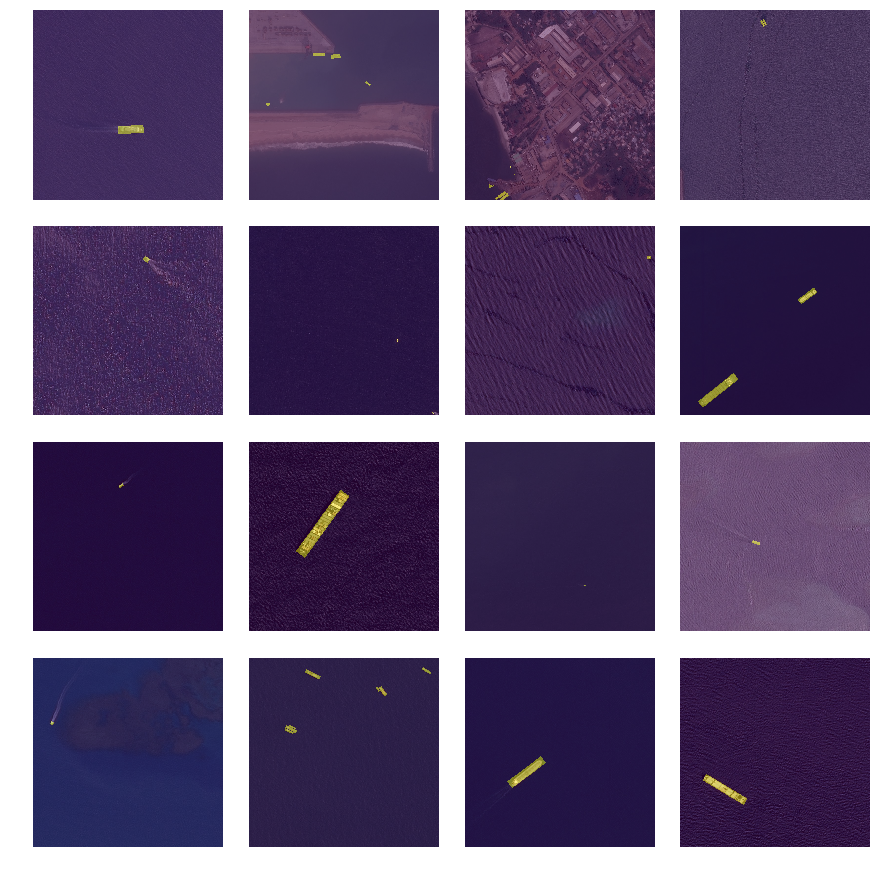

In [23]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [26]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [27]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [28]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [29]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [30]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [31]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [32]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [33]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [34]:
sz = 256
bs = 48

tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [35]:
md = md.resize(256, 'tmp')

In [36]:
os.makedirs(PATH/'tmp/256/masks/', exist_ok=True)
os.makedirs(PATH/'tmp/256/models/', exist_ok=True)

In [36]:
from shutil import copy2

In [38]:
for fn in mask_fns:
    copy2(PATH/'masks'/fn, PATH/'tmp/256/masks'/fn)

In [36]:
it = iter(md.trn_dl)
x,y = next(it)

In [37]:
x.shape,y.shape

(torch.Size([48, 3, 256, 256]), torch.Size([48, 256, 256]))

In [37]:
f = resnet34
cut,lr_cut = model_meta[f]

In [38]:
cut, lr_cut

(8, 6)

In [40]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [39]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [40]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.mean()

In [41]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [42]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

def IoU(pred, targs):
    pred = (pred>0).float()
    intersection = (pred*targs).sum()
    return intersection / ((pred+targs).sum() - intersection + 1.0)

Здесь мы тренируем модель на 256х256 изображениях. Обратите внимание, что для первой эпохи модель имеет точность 99,7%, но имеет значение только 75%. Это эффект классового дисбаланса. Первый обучающий блок обучает только слои после кодера. Второй тренировочный блок размораживает модель и тренирует каждый слой, в результате чего результат игры в кости составляет 87,9%.

In [45]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]

In [46]:
learn.freeze_to(1)

 82%|█████████████████████████████████████████████████████████▏            | 616/754 [04:08<00:55,  2.48it/s, loss=1.8]

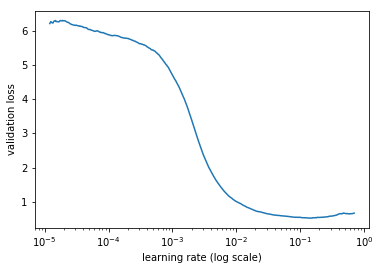

In [50]:
learn.lr_find()
learn.sched.plot()

In [51]:
lr=1e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [52]:
learn.fit(lr,1,wds=wd,cycle_len=10,use_clr=(5,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.367146   0.377047   0.997794   0.759004   0.613933  
    1      0.288314   0.320617   0.998037   0.795122   0.661618                                                        
    2      0.267707   0.269532   0.998288   0.821925   0.698836                                                        
    3      0.262305   0.265169   0.998341   0.824439   0.702712                                                        
    4      0.254063   0.242338   0.998443   0.838378   0.722694                                                        
    5      0.231813   0.229343   0.998526   0.845841   0.73381                                                         
    6      0.214011   0.223274   0.998547   0.850024   0.740012                                                        
    7      0.217105   0.215703   0.998585   0.854407   0.746505                               

[0.1979435196462403,
 0.9986947536767323,
 0.8654592703656121,
 0.7634150314980982]

In [53]:
learn.save('256_r34_1')

In [ ]:
learn.load('256_r34_1')

In [54]:
learn.unfreeze()
learn.bn_freeze(True)

In [55]:
learn.fit(lrs/5, 1, wds=wd, cycle_len=10, use_clr=(20,10))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.178505   0.19466    0.998715   0.867784   0.767025  
    1      0.17779    0.190533   0.998745   0.870171   0.770772                                                        
    2      0.171578   0.188846   0.998753   0.871099   0.772225                                                        
    3      0.172554   0.186271   0.998771   0.872795   0.774944                                                        
    4      0.163993   0.181724   0.998794   0.875855   0.779683                                                        
    5      0.163033   0.179935   0.998805   0.87704    0.781529                                                        
    6      0.162994   0.179569   0.998806   0.876881   0.781315                                                        
    7      0.165723   0.177162   0.998821   0.878567   0.783971                               

[0.17544782397497902,
 0.9988311088871437,
 0.8797841977124377,
 0.7858963072832225]

In [56]:
learn.save('256_r34_2')

In [57]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Here we can see areas in which the model typically struggles. It correctly identifies every ship in the image. However, the masks are blobby, rather than having the sharp corners of the ground truth mask. In fact the model prefers to mask only the ship itself, leading to difficulties in replicating the ground truth masks.

The model also struggles to separate ships that are next to each other, preferring to classify them all as a single object.

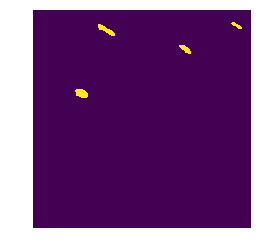

In [58]:
show_img(py[3] > 0)

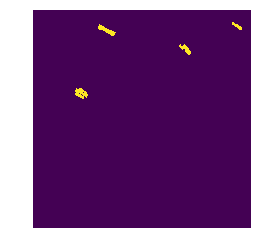

In [59]:
show_img(y[3])

# 512x512

Now we increase the image size to 512x512 and continue training.

In [60]:
sz = 512
bs = 14

In [61]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [62]:
md = md.resize(512, 'tmp')

In [63]:
os.makedirs(PATH/'tmp/512/masks/', exist_ok=True)
os.makedirs(PATH/'tmp/512/models/', exist_ok=True)

In [64]:
for fn in mask_fns:
    copy2(PATH/'masks'/fn, PATH/'tmp/512/masks'/fn)

In [65]:
copy2(PATH/'tmp/256/models/256_r34_2.h5', PATH/'tmp/512/models/')

'F:\\ships\\tmp\\512\\models\\256_r34_2.h5'

In [66]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [67]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]

In [68]:
learn.freeze_to(1)

In [69]:
learn.load('256_r34_2')

 68%|█████████████████████████████████████████████                     | 1766/2584 [11:58<05:33,  2.46it/s, loss=0.898]

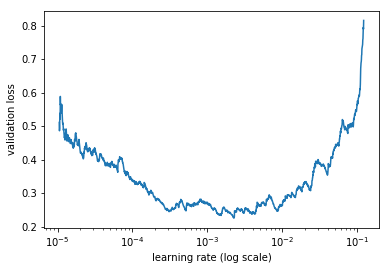

In [70]:
learn.lr_find()
learn.sched.plot()

In [71]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [72]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.20126    0.20648    0.998703   0.860541   0.758702  
    1      0.19053    0.179549   0.998845   0.877065   0.783146                                                        
    2      0.167932   0.168454   0.998909   0.884335   0.794422                                                        
    3      0.160386   0.162098   0.998949   0.888294   0.800697                                                        
    4      0.149346   0.157657   0.998974   0.891119   0.805231                                                        


[0.15765728231051976,
 0.9989741634990137,
 0.8911189321214347,
 0.8052312636681714]

In [73]:
learn.save('512_r34_1')

In [74]:
learn.unfreeze()
learn.bn_freeze(True)

Training at this image size increases the dice score to 89.3.

In [75]:
learn.fit(lrs/10,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.14604    0.157239   0.998979   0.891647   0.806126  
    1      0.149588   0.156214   0.998985   0.892156   0.806927                                                        
    2      0.145757   0.155404   0.99899    0.892785   0.807963                                                        
    3      0.157645   0.154956   0.998993   0.893094   0.808458                                                        
    4      0.142126   0.154969   0.998992   0.893018   0.808334                                                        


[0.15496914572202541,
 0.9989920675184927,
 0.8930181278790984,
 0.8083343859397186]

In [76]:
learn.save('512_r34_2')

# 768x768

Finally we train on full size 768x768 images.

In [43]:
sz = 768
bs = 6

In [44]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=8, classes=None)
denorm = md.trn_ds.denorm

In [79]:
copy2(PATH/f'tmp/512/models/512_r34_2.h5', PATH/f'models/')

'F:\\ships\\models\\512_r34_2.h5'

In [45]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [46]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam

learn.crit = MixedLoss(10.0, 2.0)
learn.metrics=[accuracy_thresh(0.5),dice,IoU]

In [82]:
learn.freeze_to(1)

In [83]:
learn.load('512_r34_2')

 60%|███████████████████████████████████████▊                          | 3642/6029 [23:31<15:24,  2.58it/s, loss=0.717]

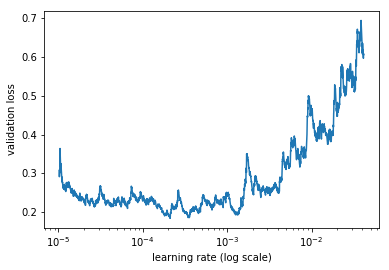

In [84]:
learn.lr_find()
learn.sched.plot()

In [85]:
lr=1e-3
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [86]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.206165   0.204162   0.998823   0.862997   0.766454  
    1      0.206211   0.185735   0.998933   0.87425    0.783253                                                        
    2      0.19352    0.171071   0.998986   0.882044   0.793666                                                        
    3      0.153902   0.156915   0.999073   0.891423   0.808541                                                        
    4      0.159421   0.149873   0.999108   0.895903   0.815623                                                        


[0.14987298815546038,
 0.9991079148838331,
 0.8959027836824424,
 0.8156232332223339]

In [87]:
learn.save('768_r34_1')

In [47]:
learn.unfreeze()
learn.bn_freeze(True)

Training on full size images brings the dice score to 89.99

In [89]:
learn.fit(lrs/10,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.140463   0.147419   0.999123   0.897639   0.81833   
    1      0.150151   0.145796   0.99913    0.8985     0.819677                                                        
    2      0.142684   0.145052   0.999135   0.899169   0.820717                                                        
    3      0.150585   0.144329   0.999139   0.899597   0.821425                                                        
    4      0.139405   0.143756   0.999141   0.899975   0.821968                                                        


[0.14375629796165482,
 0.9991409047987512,
 0.8999754052802386,
 0.8219675962153262]

In [90]:
learn.save('768_r34_2')

In [91]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

Comparing to the model trained on 256x256 images, the model is now much better at producing square-ish masks. The model still struggles to separate ships docked together.

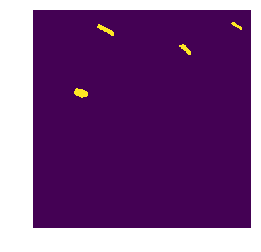

In [92]:
show_img(py[3] > 0)

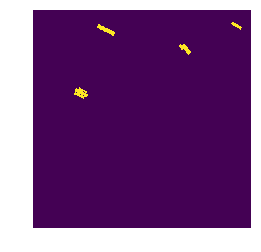

In [93]:
show_img(y[3])

To fine tune the model, we train for a few epochs using a Lovasz loss, adapted from [this repo](https://github.com/bermanmaxim/LovaszSoftmax)

In [48]:
"""
Lovasz-Softmax and Jaccard hinge loss in PyTorch
Maxim Berman 2018 ESAT-PSI KU Leuven (MIT License)
"""

from __future__ import print_function, division

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
try:
    from itertools import  ifilterfalse
except ImportError: # py3k
    from itertools import  filterfalse


def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


def iou_binary(preds, labels, EMPTY=1., ignore=None, per_image=True):
    """
    IoU for foreground class
    binary: 1 foreground, 0 background
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        intersection = ((label == 1) & (pred == 1)).sum()
        union = ((label == 1) | ((pred == 1) & (label != ignore))).sum()
        if not union:
            iou = EMPTY
        else:
            iou = float(intersection) / union
        ious.append(iou)
    iou = mean(ious)    # mean accross images if per_image
    return 100 * iou


def iou(preds, labels, C, EMPTY=1., ignore=None, per_image=False):
    """
    Array of IoU for each (non ignored) class
    """
    if not per_image:
        preds, labels = (preds,), (labels,)
    ious = []
    for pred, label in zip(preds, labels):
        iou = []    
        for i in range(C):
            if i != ignore: # The ignored label is sometimes among predicted classes (ENet - CityScapes)
                intersection = ((label == i) & (pred == i)).sum()
                union = ((label == i) | ((pred == i) & (label != ignore))).sum()
                if not union:
                    iou.append(EMPTY)
                else:
                    iou.append(float(intersection) / union)
        ious.append(iou)
    ious = map(mean, zip(*ious)) # mean accross images if per_image
    return 100 * np.array(ious)


# --------------------------- BINARY LOSSES ---------------------------


def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss


def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.elu(errors_sorted) +1, Variable(grad))
    return loss


def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels


class StableBCELoss(torch.nn.modules.Module):
    def __init__(self):
         super(StableBCELoss, self).__init__()
    def forward(self, input, target):
         neg_abs = - input.abs()
         loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
         return loss.mean()


def binary_xloss(logits, labels, ignore=None):
    """
    Binary Cross entropy loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      ignore: void class id
    """
    logits, labels = flatten_binary_scores(logits, labels, ignore)
    loss = StableBCELoss()(logits, Variable(labels.float()))
    return loss


# --------------------------- MULTICLASS LOSSES ---------------------------


def lovasz_softmax(probas, labels, only_present=False, per_image=False, ignore=None):
    """
    Multi-class Lovasz-Softmax loss
      probas: [B, C, H, W] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [B, H, W] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
      per_image: compute the loss per image instead of per batch
      ignore: void class labels
    """
    if per_image:
        loss = mean(lovasz_softmax_flat(*flatten_probas(prob.unsqueeze(0), lab.unsqueeze(0), ignore), only_present=only_present)
                          for prob, lab in zip(probas, labels))
    else:
        loss = lovasz_softmax_flat(*flatten_probas(probas, labels, ignore), only_present=only_present)
    return loss


def lovasz_softmax_flat(probas, labels, only_present=False):
    """
    Multi-class Lovasz-Softmax loss
      probas: [P, C] Variable, class probabilities at each prediction (between 0 and 1)
      labels: [P] Tensor, ground truth labels (between 0 and C - 1)
      only_present: average only on classes present in ground truth
    """
    C = probas.size(1)
    losses = []
    for c in range(C):
        fg = (labels == c).float() # foreground for class c
        if only_present and fg.sum() == 0:
            continue
        errors = (Variable(fg) - probas[:, c]).abs()
        errors_sorted, perm = torch.sort(errors, 0, descending=True)
        perm = perm.data
        fg_sorted = fg[perm]
        losses.append(torch.dot(errors_sorted, Variable(lovasz_grad(fg_sorted))))
    return mean(losses)


def flatten_probas(probas, labels, ignore=None):
    """
    Flattens predictions in the batch
    """
    B, C, H, W = probas.size()
    probas = probas.permute(0, 2, 3, 1).contiguous().view(-1, C)  # B * H * W, C = P, C
    labels = labels.view(-1)
    if ignore is None:
        return probas, labels
    valid = (labels != ignore)
    vprobas = probas[valid.nonzero().squeeze()]
    vlabels = labels[valid]
    return vprobas, vlabels

def xloss(logits, labels, ignore=None):
    """
    Cross entropy loss
    """
    return F.cross_entropy(logits, Variable(labels), ignore_index=255)


# --------------------------- HELPER FUNCTIONS ---------------------------

def mean(l, ignore_nan=False, empty=0):
    """
    nanmean compatible with generators.
    """
    l = iter(l)
    if ignore_nan:
        l = ifilterfalse(np.isnan, l)
    try:
        n = 1
        acc = next(l)
    except StopIteration:
        if empty == 'raise':
            raise ValueError('Empty mean')
        return empty
    for n, v in enumerate(l, 2):
        acc += v
    if n == 1:
        return acc
    return acc / n

In [49]:
class LovaszLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)
        
    def forward(self, input, target):
        probs = torch.sigmoid(input)
        
        loss = self.alpha * self.focal(input, target) + lovasz_softmax(probs.unsqueeze(1), target)
        return loss.mean()

In [50]:
learn.crit = LovaszLoss(10, 2)

In [51]:
learn.load('768_r34_2')

 43%|██████████████████████████████                                        | 2593/6029 [19:35<25:58,  2.21it/s, loss=1]

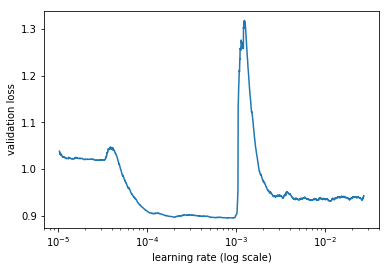

In [52]:
learn.lr_find(end_lr=1000)
learn.sched.plot()

In [53]:
lr=1e-4
wd=1e-7

lrs = np.array([lr/50,lr/10,lr])

In [54]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.894734   0.905061   0.997484   0.695274   0.558768  
    1      0.88988    0.891366   0.998709   0.849389   0.749565                                                        
    2      0.888861   0.889073   0.998894   0.892695   0.810716                                                        
    3      0.888293   0.888796   0.998993   0.897427   0.817782                                                        
    4      0.888175   0.888526   0.999012   0.90259    0.826162                                                        


[0.8885257733703015, 0.9990122527906593, 0.9025900561421452, 0.826162069895864]

In [55]:
learn.save('768_L_1')

This brings our dice score to 91.0

In [56]:
learn.fit(lr/5,1,wds=wd, cycle_len=5,use_clr=(20,5))

epoch      trn_loss   val_loss   <lambda>   dice       IoU                                                             
    0      0.888375   0.888603   0.998994   0.900724   0.82338   
    1      0.888086   0.888365   0.999037   0.905216   0.830449                                                        
    2      0.88833    0.888258   0.999062   0.907663   0.834019                                                        
    3      0.888356   0.888155   0.999033   0.909183   0.836732                                                        
    4      0.88799    0.888095   0.999067   0.910245   0.838568                                                        


[0.8880946587922337,
 0.9990666957460338,
 0.9102452771614734,
 0.8385684289529595]

In [57]:
learn.save('768_L_2')

In [59]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

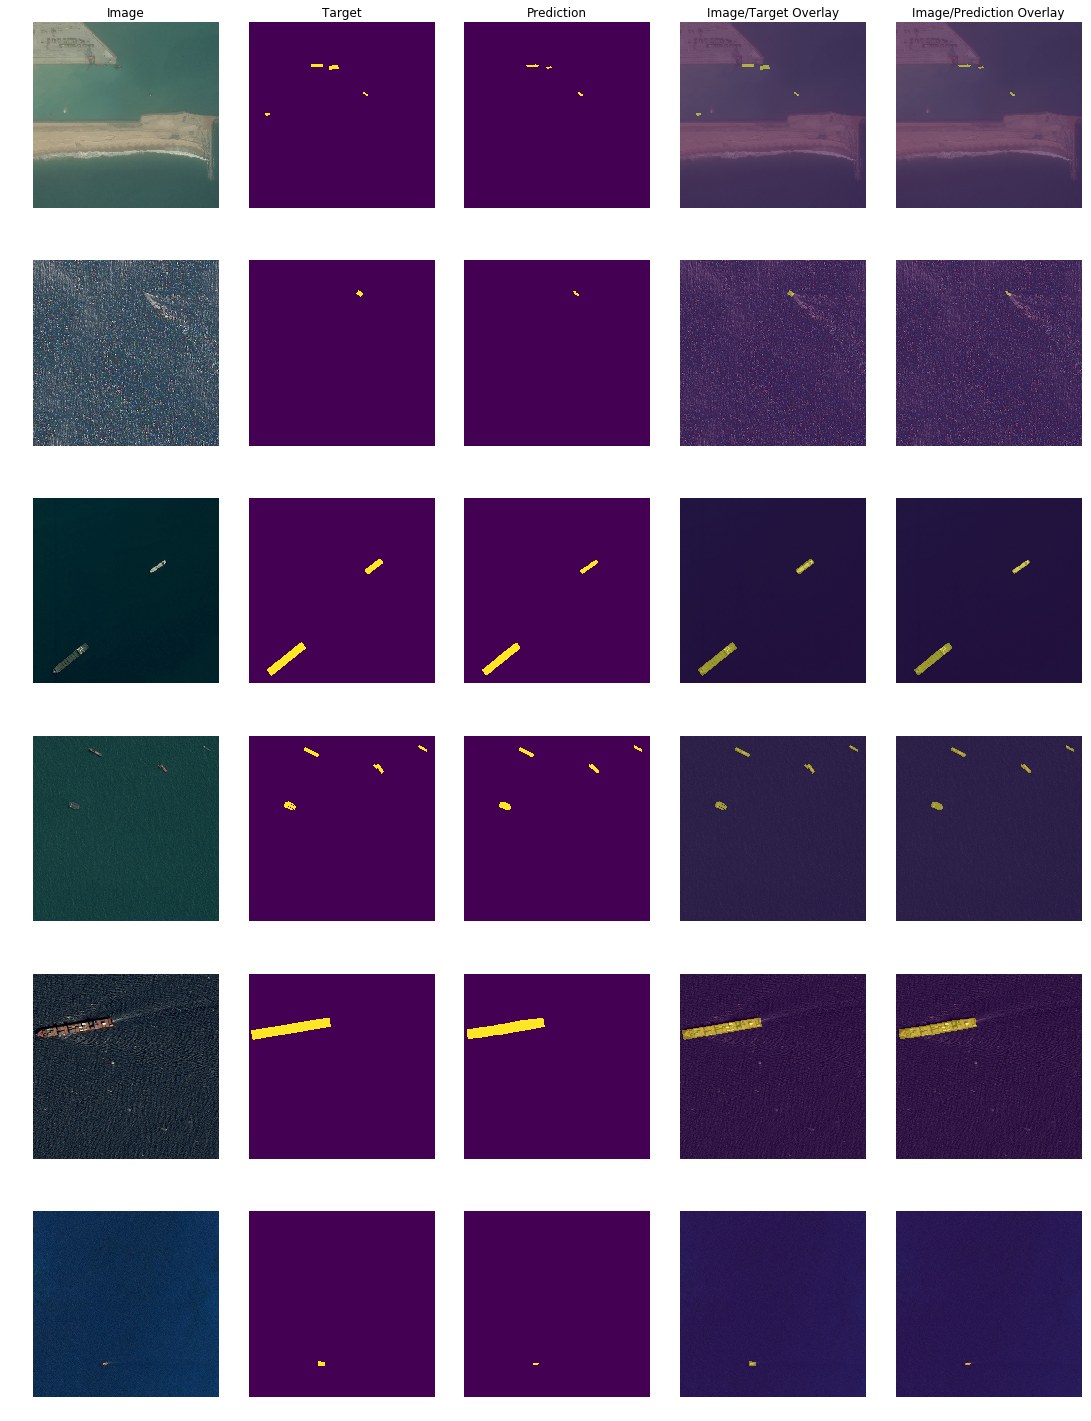

In [60]:
fig, axes = plt.subplots(6 , 5, figsize = (15,20))

cols = ['Image', 'Target', 'Prediction', 'Image/Target Overlay', 'Image/Prediction Overlay']

for ax, col in zip(axes[0], cols):
    ax.set_title(col)

for i in range(6):
    axes[i][0] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][0])
    axes[i][1] = show_img(y[i], ax = axes[i][1])
    axes[i][2] = show_img(py[i] > 0, ax = axes[i][2])
    axes[i][3] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][3])
    axes[i][3] = show_img(y[i], ax = axes[i][3], alpha=0.5)
    axes[i][4] = show_img(denorm(x[i]).squeeze(0), ax = axes[i][4])
    axes[i][4] = show_img(py[i] > 0, ax = axes[i][4], alpha=0.5)
    
plt.tight_layout(pad=0.1)